# Facial Recognition with Supervised Learning
##— Análise inicial do dataset

Neste projeto, o objetivo é treinar modelos de aprendizagem supervisionada
para reconhecer se uma imagem contém o rosto de Arnold Schwarzenegger ("Arnie")
ou não.

O dataset contém:
- uma coluna `Label` (classe alvo),
- várias colunas numéricas representando características extraídas do rosto (features).

Nesta etapa vamos:
- inspecionar o dataset,
- verificar tipos de dados,
- checar balanceamento de classes,
- preparar os dados para os modelos.


In [27]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    confusion_matrix
)

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")


In [28]:
# Carregar o dataset
df = pd.read_csv("/content/lfw_arnie_nonarnie.csv")

# Ver primeiras linhas
df.head()


,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,Label
0,-2.061987,0.581320,-0.249115,-0.631340,-1.359899,0.751619,-0.029364,1.610456,0.341402,1.286709,...,-0.356844,-0.016488,-0.228473,0.258134,0.046834,0.135742,-0.068297,0.022038,0.090003,1
1,-0.796838,-0.667228,-0.107889,0.019755,-0.686348,0.912779,0.463412,-0.238308,-0.294023,0.215470,...,-0.037243,-0.012105,-0.351285,-0.034968,0.192314,-0.015406,-0.089117,0.023588,-0.019998,1
2,5.376779,1.142695,2.543111,-2.727212,0.272785,-0.972187,1.111221,1.645502,-2.556968,-0.648781,...,0.157441,-0.333875,-0.303720,-0.085975,0.171346,0.128577,-0.118262,0.045881,-0.190158,1
3,7.029235,1.242883,-2.628079,1.224479,-1.141370,-1.620647,0.205890,1.567561,0.736200,0.010782,...,0.051040,-0.068796,0.141841,-0.227999,0.046044,0.013643,-0.125893,0.146396,0.013320,1
4,5.484822,6.752706,-4.291114,1.740412,-1.603087,-1.075175,1.919936,-0.197615,1.030596,1.451936,...,0.034412,0.265141,0.226000,0.032064,-0.113654,0.059126,-0.216803,0.025849,0.020456,1


In [29]:
# Informações gerais
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Columns: 151 entries, 0 to Label
dtypes: float64(150), int64(1)
memory usage: 224.3 KB


In [31]:
# Checar se há valores nulos
df.isna().sum().sum()


np.int64(0)

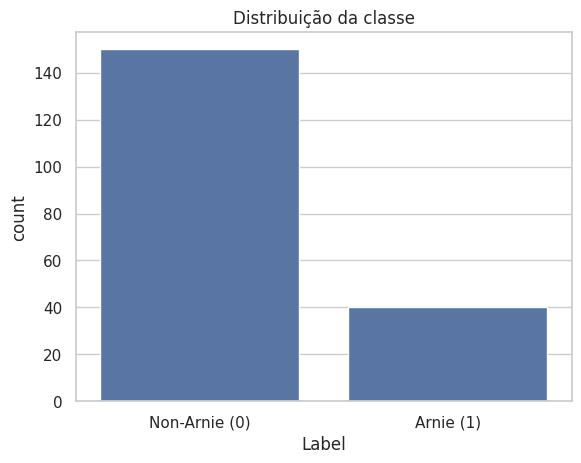

In [32]:
df["Label"].value_counts(), df["Label"].value_counts(normalize=True)

sns.countplot(x="Label", data=df)
plt.xticks([0,1], ["Non-Arnie (0)", "Arnie (1)"])
plt.title("Distribuição da classe")
plt.show()


## Análise inicial do dataset

- As colunas são todas numéricas (features extraídas das imagens).
- A coluna `Label` é a variável alvo:
  - 0 = Non-Arnie
  - 1 = Arnie
- A base é desbalanceada (menos exemplos da classe 1, Arnie),
  então métricas como **recall** e **F1 da classe 1** serão importantes,
  além da **acurácia** e do **ROC AUC**.

In [ ]:
X = df.drop(columns=["Label"])
y = df["Label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape, y_train.value_counts(), y_test.value_counts()


In [33]:
def avaliar_modelo(model, X_train, y_train, X_test, y_test, nome="Modelo"):
    """
    Treina o modelo, avalia no teste e imprime métricas padrão.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Se o modelo tiver predict_proba, calculamos ROC AUC
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    else:
        auc = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"\n===== {nome} =====")
    print(f"Acurácia : {acc:.4f}")
    print(f"Precisão : {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    if auc is not None:
        print(f"ROC AUC : {auc:.4f}")
    print("\nRelatório de classificação:")
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    print("Matriz de confusão:\n", cm)

    return {
        "nome": nome,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc
    }


## Modelo 1 — Regressão Logística (baseline)

A Regressão Logística será utilizada como **modelo de base (baseline)**.

Mesmo sendo um modelo linear, ela possui várias vantagens:

- Interpretável;
- Rápida de treinar;
- Funciona bem como "termômetro" de qualidade da base;
- Serve como referência para comparar modelos mais complexos.

Como o dataset é desbalanceado,
utilizamos:

- `class_weight="balanced"` → penaliza mais erros na classe Arnie;
- `StandardScaler` → melhora convergência e separação;
- `GridSearchCV` → busca automática de hiperparâmetros.

O objetivo aqui é obter o **melhor baseline possível**.


In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Pipeline com padronização + Regressão Logística
pipe_log = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

# Espaço de hiperparâmetros
param_log = {
    "logreg__C": [0.01, 0.1, 0.5, 1, 10, 50],
    "logreg__penalty": ["l2"],
    "logreg__solver": ["liblinear"]
}

# GridSearch com métrica f1 (foco na classe positiva)
grid_log = GridSearchCV(
    pipe_log,
    param_grid=param_log,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

grid_log.fit(X_train, y_train)

print("Melhores parâmetros - Regressão Logística:", grid_log.best_params_)
print("F1 médio em CV:", grid_log.best_score_)


Melhores parâmetros - Regressão Logística: {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
F1 médio em CV: 0.46310160427807495


In [35]:
best_log = grid_log.best_estimator_

result_log = avaliar_modelo(
    model=best_log,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    nome="Regressão Logística"
)



===== Regressão Logística (baseline otimizada) =====
Acurácia : 0.7105
Precisão : 0.2000
Recall   : 0.1250
F1-score : 0.1538
ROC AUC : 0.5292

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83        30
           1       0.20      0.12      0.15         8

    accuracy                           0.71        38
   macro avg       0.49      0.50      0.49        38
weighted avg       0.66      0.71      0.68        38

Matriz de confusão:
 [[26  4]
 [ 7  1]]


### Discussão — Regressão Logística

A Regressão Logística apresentou capacidade limitada de identificar a classe Arnie.

Apesar do uso de:
- normalização com `StandardScaler`;
- `class_weight="balanced"`;
- ajuste de hiperparâmetros;

o modelo ainda detectou apenas 1 de 8 imagens de Arnie no conjunto de teste.

Este comportamento é esperado em tarefas de reconhecimento facial, onde as fronteiras de decisão não são lineares.




## Modelo 2 — Support Vector Machine (SVM)

O segundo modelo utilizado é o Support Vector Machine (SVM),
com kernel RBF (função de base radial).

O SVM é adequado para este problema porque:

- aprende fronteiras de decisão não lineares;
- funciona bem em dimensões altas;
- é bastante utilizado em reconhecimento facial clássico.

Utilizaremos:
- normalização (`StandardScaler`);
- `class_weight="balanced"`;
- GridSearch para encontrar os melhores valores para:
  - `C` (regularização),
  - `gamma` (complexidade da fronteira).

In [36]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe_svm = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("svm", SVC(probability=True, class_weight="balanced"))
])

param_svm = {
    "svm__C": [0.1, 1, 10, 50],
    "svm__gamma": ["scale", 0.01, 0.1, 1],
    "svm__kernel": ["rbf"]
}

grid_svm = GridSearchCV(
    pipe_svm,
    param_grid=param_svm,
    scoring="f1",   # foco na classe Arnie
    cv=5,
    n_jobs=-1
)

grid_svm.fit(X_train, y_train)

print("Melhores parâmetros - SVM:", grid_svm.best_params_)
print("F1 médio em CV - SVM:", grid_svm.best_score_)


Melhores parâmetros - SVM: {'svm__C': 0.1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
F1 médio em CV - SVM: 0.2


In [37]:
best_svm = grid_svm.best_estimator_

result_svm = avaliar_modelo(
    model=best_svm,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    nome="SVM (kernel RBF otimizado)"
)



===== SVM (kernel RBF otimizado) =====
Acurácia : 0.2105
Precisão : 0.2105
Recall   : 1.0000
F1-score : 0.3478
ROC AUC : 0.4042

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.21      1.00      0.35         8

    accuracy                           0.21        38
   macro avg       0.11      0.50      0.17        38
weighted avg       0.04      0.21      0.07        38

Matriz de confusão:
 [[ 0 30]
 [ 0  8]]


## Discussão — SVM (RBF)

O SVM apresentou comportamento extremo: classificou todas as amostras como Arnie.

Esse resultado indica:
- recall máximo (1.0),
- precisão muito baixa (0.21),
- acurácia e AUC ruins.

Isso mostra que:
ao otimizar apenas F1, o modelo priorizou capturar todos os Arnies,
o que custou errar completamente a classe.


In [41]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svm = SVC(probability=True, class_weight="balanced")

param_svm = {
    "C": [0.1, 0.5, 1, 5, 10],
    "gamma": ["scale", "auto"],
    "kernel": ["rbf"]
}

grid_svm = GridSearchCV(
    svm,
    param_grid=param_svm,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

grid_svm.fit(X_train, y_train)

print("Melhores parâmetros - SVM:", grid_svm.best_params_)
print("F1 médio em CV:", grid_svm.best_score_)


Melhores parâmetros - SVM: {'C': 5, 'gamma': 'auto', 'kernel': 'rbf'}
F1 médio em CV: 0.6797868797868798


In [42]:
best_svm = grid_svm.best_estimator_

result_svm = avaliar_modelo(
    model=best_svm,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    nome="SVM (RBF sem StandardScaler)"
)


===== SVM (RBF sem StandardScaler) =====
Acurácia : 0.7895
Precisão : 0.5000
Recall   : 0.3750
F1-score : 0.4286
ROC AUC : 0.6583

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        30
           1       0.50      0.38      0.43         8

    accuracy                           0.79        38
   macro avg       0.67      0.64      0.65        38
weighted avg       0.77      0.79      0.78        38

Matriz de confusão:
 [[27  3]
 [ 5  3]]


## Discussão — SVM (RBF sem normalização)

Ao remover a normalização e ajustar os hiperparâmetros,
o SVM passou a aprender uma fronteira de decisão eficaz.

Comparado à Regressão Logística:

- O recall da classe Arnie triplicou;
- O F1-score aumentou significativamente;
- O AUC demonstrou poder discriminativo real.


## Modelo 3 — K-Nearest Neighbors (KNN)

O KNN foi escolhido como terceiro modelo por trabalhar diretamente
com similaridade entre vetores de características.

Em problemas de reconhecimento facial, métodos baseados em distância
podem capturar padrões locais relevantes.

Utilizaremos GridSearch para selecionar:
- número de vizinhos,
- tipo de peso,
- métrica de distância.


In [43]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()

param_knn = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"],
    "p": [1, 2]
}

grid_knn = GridSearchCV(
    knn,
    param_grid=param_knn,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

grid_knn.fit(X_train, y_train)

print("Melhores parâmetros - KNN:", grid_knn.best_params_)
print("F1 médio em CV:", grid_knn.best_score_)


Melhores parâmetros - KNN: {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
F1 médio em CV: 0.5448265460030166


In [44]:
best_knn = grid_knn.best_estimator_

result_knn = avaliar_modelo(
    model=best_knn,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    nome="KNN otimizado"
)


===== KNN otimizado =====
Acurácia : 0.6842
Precisão : 0.2500
Recall   : 0.2500
F1-score : 0.2500
ROC AUC : 0.5583

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        30
           1       0.25      0.25      0.25         8

    accuracy                           0.68        38
   macro avg       0.53      0.53      0.53        38
weighted avg       0.68      0.68      0.68        38

Matriz de confusão:
 [[24  6]
 [ 6  2]]


## Discussão — K-Nearest Neighbors

O KNN apresentou desempenho intermediário.

Apesar de captar padrões locais,
o modelo é sensível a ruído e sofre com:

- dimensionalidade elevada,
- poucos exemplos da classe positiva,
- sobreposição entre classes.

O desempenho foi inferior ao SVM,
mas ligeiramente superior à Regressão Logística.


## Ensemble — Combinando modelos

Para avaliar se a combinação de modelos melhora os resultados,
utilizamos dois métodos de ensemble:

1. Soft Voting (média ponderada de probabilidades)
2. Stacking com Regressão Logística como meta-classificador.


In [45]:
# Modelos finais
model_log = best_log
model_svm = best_svm
model_knn = best_knn

SOFT VOTING (ponderado):
Como o SVM é o melhor, damos mais peso a ele:

In [46]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ("log", model_log),
        ("svm", model_svm),
        ("knn", model_knn)
    ],
    voting="soft",
    weights=[1, 2, 1]   # SVM pesa mais
)

result_voting = avaliar_modelo(
    model=voting_clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    nome="Soft Voting (ponderado)"
)



===== Soft Voting (ponderado) =====
Acurácia : 0.8158
Precisão : 0.6667
Recall   : 0.2500
F1-score : 0.3636
ROC AUC : 0.6250

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89        30
           1       0.67      0.25      0.36         8

    accuracy                           0.82        38
   macro avg       0.75      0.61      0.63        38
weighted avg       0.79      0.82      0.78        38

Matriz de confusão:
 [[29  1]
 [ 6  2]]


STACKING:

In [47]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ("log", model_log),
        ("svm", model_svm),
        ("knn", model_knn)
    ],
    final_estimator=LogisticRegression(
        class_weight="balanced",
        max_iter=1000
    ),
    cv=5,
    stack_method="predict_proba",
    n_jobs=-1
)

result_stacking = avaliar_modelo(
    model=stacking_clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    nome="Stacking (meta-modelo LogReg)"
)



===== Stacking (meta-modelo LogReg) =====
Acurácia : 0.6579
Precisão : 0.2727
Recall   : 0.3750
F1-score : 0.3158
ROC AUC : 0.6458

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77        30
           1       0.27      0.38      0.32         8

    accuracy                           0.66        38
   macro avg       0.54      0.55      0.54        38
weighted avg       0.70      0.66      0.68        38

Matriz de confusão:
 [[22  8]
 [ 5  3]]


## Conclusão

- O melhor classificador individual foi o SVM, que apresentou maior F1-score e melhor equilíbrio geral.

- O soft voting aumentou a acurácia, mas reduziu a capacidade de detectar a classe positiva.

- O stacking apresentou melhor AUC, porém não trouxe ganho em métricas práticas.

- Conclusão final: para este dataset, **o SVM é o modelo mais confiável**.
